In [1]:
import argparse
import pandas as pd
import math
import numpy as np
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix, roc_auc_score, precision_recall_fscore_support, accuracy_score, balanced_accuracy_score
import sys
from datetime import datetime
import pickle
import matplotlib.pyplot as plt
import os
import seaborn as sns
%matplotlib inline

# Set font properties
plt.rcParams.update({
    'font.size': 16,       # Set font size
    'font.weight': 'bold'  # Set font weight to bold
})

In [2]:
res = pd.read_parquet('../tidy_data/demographics/test_bootstrap_results.parquet')

In [8]:
res.head()

,bootstrap,TN,FP,FN,TP,auroc,avg_prec,best_thresh,best_f3,accuracy,balanced_acc,prec_neg,prec_pos,rec_neg,rec_pos,f3_neg,f3_pos
0,0,8203,2067,160,182,0.743183,0.075253,0.035859,0.397112,0.790143,0.665449,0.980868,0.080925,0.798734,0.532164,0.813846,0.341656
1,1,8182,2038,175,217,0.737672,0.089935,0.035859,0.397112,0.791462,0.677079,0.979059,0.096231,0.800587,0.553571,0.815452,0.375238
2,2,8237,2013,156,206,0.761007,0.087677,0.035859,0.397112,0.795609,0.686335,0.981413,0.092835,0.803610,0.569061,0.818437,0.376118
3,3,8280,1959,142,231,0.778479,0.106262,0.035859,0.397112,0.802017,0.713988,0.983139,0.105479,0.808673,0.619303,0.823283,0.416441
4,4,8189,2087,147,189,0.736333,0.076974,0.035859,0.397112,0.789484,0.679703,0.982366,0.083040,0.796905,0.562500,0.812240,0.356604


(array([   9.,   72.,  389., 1473., 2795., 3037., 1685.,  478.,   58.,
           4.]),
 array([0.70607458, 0.71631259, 0.72655061, 0.73678862, 0.74702664,
        0.75726465, 0.76750267, 0.77774068, 0.78797869, 0.79821671,
        0.80845472]),
 <BarContainer object of 10 artists>)

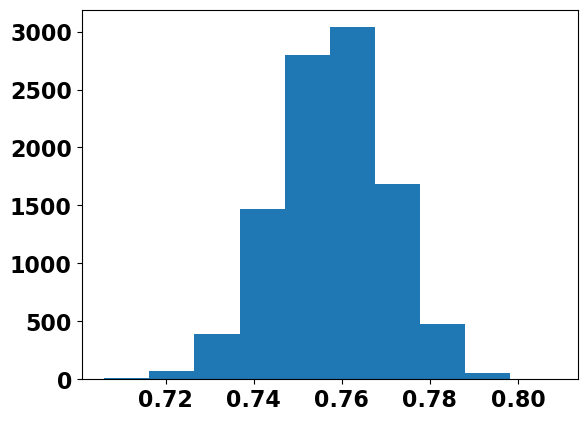

In [6]:
plt.hist(res.auroc)

In [1]:
'''
473 variables used to predict CVD in this paper:
https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0213653
Have to get the Field IDs because they don't list them. Below is 310 variables, 163 missing, guessing they are all in S3b (types/behavior of cancer) and S3d (history of illness)
Supplementary tables
S1: 27 variables
S2: 29
S3a: 18 
S3b: 5
S3c: 14
S3d: 32
S4: 39
S5: 55
S6: 20
S7a: 7
S7b: 8
S7c: 6
S7d: 4
S7e: 5
S8a: 6
S8b: 7
S8c: 6
S9a: 9
S9b: 13


'''
s1 = [30000, 30010, 30070, 30100, 30110, 30160, 30180, 30210, 30230, 30030, 30020, 30040, 30090, 30080, 30130, 30190, 30220, 30250, 30060, 30120, 30290, 30140, 30150, 
            30170, 30200, 30240, 30260]

s2 = 

310

In [23]:
prot = pd.read_parquet('../tidy_data/proteomics_first_occurrences.parquet')

In [28]:
prot.shape

(53014, 3536)

In [37]:
len(prot.columns[2924:3531])

607

In [3]:
alleles = pd.read_csv('/n/groups/patel/randy/proj_idp/tidy_data/apoe4_snps/plink_outputs/apoee4_snps.raw', sep='\t')
alleles['apoe_polymorphism'] = np.nan
alleles.loc[(alleles.rs429358_C == 0) & (alleles.rs7412_T == 0), 'apoe_polymorphism'] = 'e3'
alleles.loc[(alleles.rs429358_C == 1) & (alleles.rs7412_T == 0), 'apoe_polymorphism'] = 'e4'
alleles.loc[(alleles.rs429358_C == 0) & (alleles.rs7412_T == 1), 'apoe_polymorphism'] = 'e2'

# Example merge
prot = prot.merge(alleles[['IID', 'apoe_polymorphism']], left_on='eid', right_on='IID')

/tmp/ipykernel_14668/2784256164.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'e3' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  alleles.loc[(alleles.rs429358_C == 0) & (alleles.rs7412_T == 0), 'apoe_polymorphism'] = 'e3'


In [4]:
acd = pd.read_parquet('../../proj_idp/tidy_data/acd/allcausedementia.parquet')
prot['label'] = prot['eid'].isin(acd.eid).astype(int)

Text(0.5, 0, 'Age')

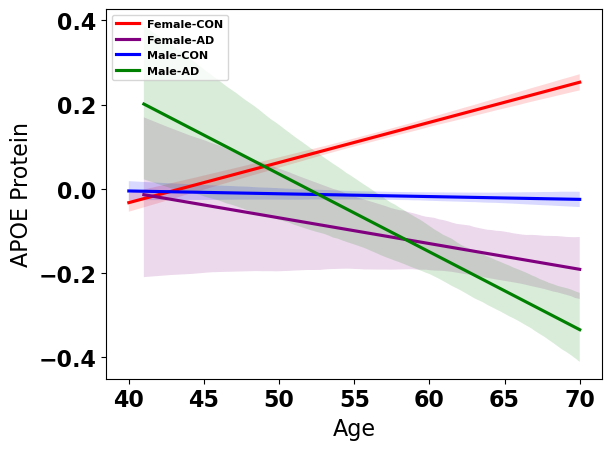

In [7]:
import seaborn as sns
protein = '154-0'
x_ci = 95
age = '21003-0.0'

sns.regplot(data=prot[ (prot['31-0.0'] == 0) & (prot.label==0) ], x=age, y=protein, scatter=False, label='Female-CON', ci=x_ci, color='red')
sns.regplot(data=prot[ (prot['31-0.0'] == 0) & (prot.label==1)], x=age, y=protein, scatter=False, label='Female-AD', ci=x_ci, color='purple')
sns.regplot(data=prot[ (prot['31-0.0'] == 1) & (prot.label==0) ], x=age, y=protein, scatter=False, label='Male-CON', ci=x_ci, color='blue')
sns.regplot(data=prot[ (prot['31-0.0'] == 1) & (prot.label==1)], x=age, y=protein, scatter=False, label='Male-AD', ci=x_ci, color='green')



# sns.regplot(data=prot[(prot.apoe_polymorphism == 'e2') & (prot['31-0.0'] == 0) & (prot.label==0) ], x='21003-0.0', y=protein, scatter=False, label='e2-female-CON', ci=x_ci, color='red')
# sns.regplot(data=prot[(prot.apoe_polymorphism == 'e2') & (prot['31-0.0'] == 0) & (prot.label==1)], x='21003-0.0', y=protein, scatter=False, label='e2-female-AD', ci=x_ci, color='brown')

# sns.regplot(data=prot[(prot.apoe_polymorphism == 'e2') & (prot['31-0.0'] == 1) & (prot.label==0)], x='21003-0.0', y=protein, scatter=False, label='e2-male-CON', ci=x_ci, color='green')
# sns.regplot(data=prot[(prot.apoe_polymorphism == 'e2') & (prot['31-0.0'] == 1) & (prot.label==1)], x='21003-0.0', y=protein, scatter=False, label='e2-male-AD', ci=x_ci, color='black')

# sns.regplot(data=prot[(prot.apoe_polymorphism == 'e3') & (prot['31-0.0'] == 0) & (prot.label==0)], x='21003-0.0', y=protein, scatter=False, label='e3-female-CON', ci=x_ci, color='orange')
# sns.regplot(data=prot[(prot.apoe_polymorphism == 'e3') & (prot['31-0.0'] == 0) & (prot.label==1)], x='21003-0.0', y=protein, scatter=False, label='e3-female-AD', ci=x_ci, color='#1EAB46')

# sns.regplot(data=prot[(prot.apoe_polymorphism == 'e3') & (prot['31-0.0'] == 1) & (prot.label==0)], x='21003-0.0', y=protein, scatter=False, label='e3-male-CON', ci=x_ci, color='yellow')
# sns.regplot(data=prot[(prot.apoe_polymorphism == 'e3') & (prot['31-0.0'] == 1) & (prot.label==1)], x='21003-0.0', y=protein, scatter=False, label='e3-male-AD', ci=x_ci, color='#9196B0')

# sns.regplot(data=prot[(prot.apoe_polymorphism == 'e4') & (prot['31-0.0'] == 0) & (prot.label==0)], x='21003-0.0', y=protein, scatter=False, label='e4-female-CON', ci=x_ci, color='blue')
# sns.regplot(data=prot[(prot.apoe_polymorphism == 'e4') & (prot['31-0.0'] == 0) & (prot.label==1)], x='21003-0.0', y=protein, scatter=False, label='e4-female-AD', ci=x_ci, color='#A7369B')

# sns.regplot(data=prot[(prot.apoe_polymorphism == 'e4') & (prot['31-0.0'] == 1) & (prot.label==0)], x='21003-0.0', y=protein, scatter=False, label='e4-male-CON', ci=x_ci, color='purple')
# sns.regplot(data=prot[(prot.apoe_polymorphism == 'e4') & (prot['31-0.0'] == 1) & (prot.label==1)], x='21003-0.0', y=protein, scatter=False, label='e4-male-AD', ci=x_ci, color='#EE9898')

plt.legend(fontsize=8, loc='upper left')
plt.ylabel('APOE Protein')
plt.xlabel('Age')

In [19]:
prot.label

AttributeError: 'DataFrame' object has no attribute 'label'

In [14]:
prot[(prot.apoe_polymorphism == 'e3') & (prot['31-0.0'] == 0)]

,eid,2738-0,2737-0,2736-0,2735-0,2734-0,2733-0,2732-0,2731-0,2739-0,...,132542-0.0,132562-0.0,132574-0.0,31-0.0,53-0.0,54-0.0,21003-0.0,21003-0.0_squared,IID,apoe_polymorphism
3,1000701,0.07755,0.11670,0.10950,-0.4508,-0.19250,-0.34620,-0.40070,-1.1007,-1.31235,...,None,None,None,0,2008-07-02,11010,63,3969.0,1000701,e3
8,1000965,-0.21805,-0.07635,-0.00345,0.8309,-0.13185,-0.20925,0.05235,0.1722,-0.05675,...,None,None,None,0,2008-10-25,11008,48,2304.0,1000965,e3
9,1000992,-0.18705,0.20930,-0.04980,-0.0594,-0.19360,0.05570,0.12380,-0.2475,-0.85225,...,None,None,None,0,2009-07-14,11018,65,4225.0,1000992,e3
14,1001316,-0.06675,-0.03570,0.05800,-0.2980,-0.17120,0.00000,-0.11150,-0.0941,0.48935,...,None,None,2003-01-21,0,2009-11-11,11017,67,4489.0,1001316,e3
19,1001669,-0.04795,0.24195,-0.11385,-0.6326,0.02065,-0.06205,0.22725,0.4087,0.33945,...,None,None,None,0,2008-09-25,11009,61,3721.0,1001669,e3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52599,6022160,-0.11795,-0.01790,0.01060,1.2571,0.11140,0.55420,0.81080,-0.0939,-0.80705,...,None,None,None,0,2008-10-27,11012,59,3481.0,6022160,e3
52607,6023019,0.17915,-0.20460,-0.14120,0.1943,0.21100,0.11120,-0.30380,-0.1886,-0.69035,...,None,None,None,0,2009-01-15,11009,66,4356.0,6023019,e3
52611,6023224,0.53475,0.25490,0.16090,0.1136,0.29490,0.77510,1.00900,1.0184,0.38585,...,None,None,None,0,2009-07-06,11017,67,4489.0,6023224,e3
52623,6024239,-0.14515,-0.09850,0.44320,0.7167,-0.31370,0.01300,0.26305,-0.4723,-0.42425,...,None,None,None,0,2008-04-09,11003,40,1600.0,6024239,e3


In [2]:
def anno_protein_set(proteins):
    prot_annot = pd.read_csv('../../proj_idp/tidy_data/proteomics/coding143.tsv', sep='\t')
    prot_annot[['protein_id', 'meaning']] = prot_annot['meaning'].str.split(';', expand=True)
    prot_id = []
    for p in proteins:
        hyphen_idx = p.index('-')
        prot_id.append(int(p[:hyphen_idx]))
    sub_anno = prot_annot[prot_annot.coding.isin(prot_id)]
    return sub_anno

def pull_proteins(path, outcome, nf, iteration):
    
    for f in os.listdir(path):
        if outcome in f:
            res_file = f
            break
    
    df = pd.read_parquet(f'{path}/{f}')
    sub = df[(df.outcome == f'{outcome}-0.0') & (df.n_features == nf) & (df.iteration == iteration)].iloc[0]
    prot_df = anno_protein_set(sub.proteins.tolist())
    return prot_df
    
df = pd.read_parquet('../tidy_data/bootstrap/full_bs_results.parquet')

NameError: name 'pd' is not defined

In [17]:
top_rows = df.groupby(['n_features', 'outcome']).first().reset_index()
top_rows = top_rows.sort_values(by=['best_f1'], ascending=False)
top_rows = top_rows[top_rows.n_features != 2923]


In [31]:
outcome_top_rows = top_rows.groupby(['outcome']).first()
outcome_top_rows = outcome_top_rows.sort_values(by=['best_f1'], ascending=False)
outcome_top_rows

,n_features,iteration,bootstrap,TN,FP,FN,TP,auroc,avg_prec,best_thresh,best_f1,accuracy,balanced_acc,prec_neg,prec_pos,rec_neg,rec_pos,f1_neg,f1_pos
outcome,,,,,,,,,,,,,,,,,,,
131286,1000,42,9,4078,1981,1005,3433,0.802824,0.760981,0.439742,0.697047,0.715538,0.723298,0.802282,0.634097,0.673048,0.773547,0.732005,0.696914
130714,1000,2,83,9739,158,269,331,0.922135,0.599675,0.790388,0.609174,0.959322,0.767851,0.973122,0.676892,0.984036,0.551667,0.978548,0.607897
130814,1000,42,19,6225,1461,1020,1791,0.802629,0.624908,0.525208,0.591029,0.763647,0.723527,0.859213,0.550738,0.809914,0.637140,0.833836,0.590797
130708,1000,2,90,9016,435,428,618,0.897014,0.620651,0.701411,0.589524,0.917786,0.772398,0.954680,0.586895,0.953973,0.590822,0.954327,0.588852
132032,500,82,6,9332,357,398,410,0.872010,0.500802,0.745440,0.521574,0.928075,0.735290,0.959096,0.534550,0.963154,0.507426,0.961121,0.520635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131158,1000,12,96,10397,37,61,2,0.503765,0.009520,0.651368,0.058252,0.990664,0.514100,0.994167,0.051282,0.996454,0.031746,0.995309,0.039216
131746,50,19,95,10396,64,35,2,0.567788,0.008971,0.629286,0.057692,0.990569,0.523968,0.996645,0.030303,0.993881,0.054054,0.995261,0.038835
131580,1000,7,45,10360,38,96,3,0.508729,0.014047,0.621887,0.056738,0.987234,0.513324,0.990819,0.073171,0.996345,0.030303,0.993574,0.042857


In [39]:
df_l = []

for i in range(100):
    print(i)
    dfdf = pull_proteins('../tidy_data/bootstrap/individual_results/', str(outcome_top_rows.index.values[i]), top_rows.n_features.values[i], top_rows.iteration.values[i])
    dfdf['outcome'] = top_rows.outcome.values[i]
    dfdf['n_features'] = top_rows.n_features.values[i]
    dfdf['iteration'] = top_rows.iteration.values[i]
    df_l.append(dfdf)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [40]:
alldf = pd.concat(df_l)

In [41]:
from collections import Counter
Counter(alldf.protein_id).most_common()

[('SERPINB6', 30),
 ('CDK5RAP3', 28),
 ('NIT2', 28),
 ('ADGRE1', 27),
 ('MCAM', 27),
 ('VCAM1', 27),
 ('VSIG2', 27),
 ('CD5', 27),
 ('AMIGO2', 26),
 ('CA14', 26),
 ('DPP4', 26),
 ('PCDH7', 26),
 ('PLPBP', 26),
 ('PMVK', 26),
 ('REN', 26),
 ('GP1BB', 26),
 ('RNF5', 26),
 ('PDP1', 26),
 ('ACOX1', 25),
 ('DCC', 25),
 ('EBAG9', 25),
 ('IL1RN', 25),
 ('INSL3', 25),
 ('RIPK4', 25),
 ('TPMT', 25),
 ('ZNF830', 25),
 ('CCL26', 25),
 ('MRC1', 25),
 ('PPM1F', 25),
 ('CCL17', 25),
 ('AXL', 24),
 ('BCL2L1', 24),
 ('CAPN3', 24),
 ('EDEM2', 24),
 ('HBEGF', 24),
 ('KAZN', 24),
 ('LEO1', 24),
 ('LSM8', 24),
 ('PDRG1', 24),
 ('PPP2R5A', 24),
 ('SLITRK6', 24),
 ('UHRF2', 24),
 ('VAMP8', 24),
 ('ZNF174', 24),
 ('COQ7', 24),
 ('RNASE6', 24),
 ('IL24', 24),
 ('KIR2DL2', 24),
 ('TBC1D5', 24),
 ('TF', 24),
 ('LRP11', 24),
 ('ADAMTSL2', 23),
 ('AP1G2', 23),
 ('CHRDL1', 23),
 ('CXCL11', 23),
 ('ECHDC3', 23),
 ('ERBB2', 23),
 ('ICAM3', 23),
 ('IPCEF1', 23),
 ('KLK14', 23),
 ('MEGF9', 23),
 ('MITD1', 23),
 ('NCAM

In [54]:
top_rows = df.groupby(['n_features', 'outcome', 'iteration']).first().reset_index()
top_rows = top_rows.sort_values(by=['best_f1'], ascending=False)

In [55]:
start = 0
end = start + 50
top_rows.head()

,n_features,outcome,iteration,proteins,bootstrap,TN,FP,FN,TP,auroc,...,best_thresh,best_f1,accuracy,balanced_acc,prec_neg,prec_pos,rec_neg,rec_pos,f1_neg,f1_pos
405,1000,130004-0.0,5,"[2767-0, 1917-0, 1888-0, 1908-0, 1432-0, 1179-...",90,10477,2,17,1,0.568420,...,0.692236,0.181818,0.998190,0.527682,0.998380,0.333333,0.999809,0.055556,0.999094,0.095238
431,1000,130004-0.0,31,"[2321-0, 498-0, 2215-0, 404-0, 66-0, 1239-0, 1...",95,10479,0,18,0,0.523269,...,0.686319,0.105263,0.998285,0.500000,0.998285,0.000000,1.000000,0.000000,0.999142,0.000000
350,500,130004-0.0,50,"[914-0, 1722-0, 2537-0, 829-0, 1687-0, 1931-0,...",97,10424,55,15,3,0.618205,...,0.613036,0.103896,0.993331,0.580709,0.998563,0.051724,0.994751,0.166667,0.996654,0.078947
118,50,130004-0.0,18,"[1617-0, 2477-0, 156-0, 2837-0, 2691-0, 973-0,...",88,10478,1,18,0,0.577197,...,0.796994,0.100000,0.998190,0.499952,0.998285,0.000000,0.999905,0.000000,0.999094,0.000000
181,50,130004-0.0,81,"[1587-0, 1242-0, 2814-0, 1691-0, 1883-0, 781-0...",1,10476,2,18,0,0.553345,...,0.774643,0.095238,0.998095,0.499905,0.998285,0.000000,0.999809,0.000000,0.999046,0.000000


In [59]:
top_rows = top_rows.sort_values(by=['best_f1'], ascending=False)
tr_df = top_rows[top_rows.n_features < 2923]
# ppp = pull_proteins('../tidy_data/bootstrap/individual_results/', str(tr_df.outcome[0]), tr_df.n_features[0], tr_df.iteration[0], )

In [65]:
df.shape

(50100, 21)

In [ ]:
results

,n_features,proteins,outcome,iteration,bootstrap,TN,FP,FN,TP,auroc,...,best_thresh,best_f1,accuracy,balanced_acc,prec_neg,prec_pos,rec_neg,rec_pos,f1_neg,f1_pos
0,5,"[2607-0, 2714-0, 2171-0, 646-0, 2093-0]",130004-0.0,0,0,5236,56,9,0,0.620685,...,0.666112,0.029851,0.987738,0.494709,0.998284,0.000000,0.989418,0.000000,0.993831,0.000000
1,5,"[2607-0, 2714-0, 2171-0, 646-0, 2093-0]",130004-0.0,0,1,5292,0,10,0,0.492933,...,0.813268,0.117647,0.998114,0.500000,0.998114,0.000000,1.000000,0.000000,0.999056,0.000000
2,5,"[948-0, 250-0, 2648-0, 1608-0, 2875-0]",130004-0.0,1,0,4347,945,6,3,0.624801,...,0.402726,0.008351,0.820600,0.577381,0.998622,0.003165,0.821429,0.333333,0.901400,0.006270
3,5,"[948-0, 250-0, 2648-0, 1608-0, 2875-0]",130004-0.0,1,1,5007,285,8,2,0.585317,...,0.528834,0.020134,0.944738,0.573073,0.998405,0.006969,0.946145,0.200000,0.971573,0.013468


In [35]:
path = '../tidy_data/bootstrap/individual_results/'
outcome = str(top_rows.outcome[0])
nf = 5
iteration = 99
for f in os.listdir(path):
    if outcome in f:
        res_file = f
        break

df = pd.read_parquet(f'{path}/{f}')
sub = df[(df.outcome == f'{outcome}-0.0') & (df.n_features == nf) & (df.iteration == iteration)].iloc[0]
prot_df = anno_protein_set(sub.proteins.tolist())

In [7]:
df

,n_features,proteins,outcome,iteration,bootstrap,TN,FP,FN,TP,auroc,...,best_thresh,best_f1,accuracy,balanced_acc,prec_neg,prec_pos,rec_neg,rec_pos,f1_neg,f1_pos
0,5,"[2607-0, 2714-0, 2171-0, 646-0, 2093-0]",131036-0.0,0,0,9983,367,112,34,0.813986,...,0.783636,0.127737,0.954364,0.598709,0.988905,0.084788,0.964541,0.232877,0.976571,0.124314
1,5,"[2607-0, 2714-0, 2171-0, 646-0, 2093-0]",131036-0.0,0,1,9989,361,112,34,0.811065,...,0.783636,0.129151,0.954935,0.598999,0.988912,0.086076,0.965121,0.232877,0.976872,0.125693
2,5,"[2607-0, 2714-0, 2171-0, 646-0, 2093-0]",131036-0.0,0,2,9985,365,112,34,0.808816,...,0.783636,0.128205,0.954554,0.598806,0.988908,0.085213,0.964734,0.232877,0.976671,0.124771
3,5,"[2607-0, 2714-0, 2171-0, 646-0, 2093-0]",131036-0.0,0,3,9986,364,113,34,0.809239,...,0.783636,0.128205,0.954558,0.598062,0.988811,0.085427,0.964831,0.231293,0.976674,0.124771
4,5,"[2607-0, 2714-0, 2171-0, 646-0, 2093-0]",131036-0.0,0,4,9983,367,113,34,0.808381,...,0.783636,0.127505,0.954273,0.597917,0.988807,0.084788,0.964541,0.231293,0.976524,0.124088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50095,2923,"[800-0, 2746-0, 766-0, 2700-0, 288-0, 2820-0, ...",131036-0.0,99,95,10046,305,96,50,0.879855,...,0.660134,0.203187,0.961799,0.656500,0.990534,0.140845,0.970534,0.342466,0.980432,0.199601
50096,2923,"[800-0, 2746-0, 766-0, 2700-0, 288-0, 2820-0, ...",131036-0.0,99,96,10044,307,96,50,0.881313,...,0.660134,0.202381,0.961608,0.656403,0.990533,0.140056,0.970341,0.342466,0.980333,0.198807
50097,2923,"[800-0, 2746-0, 766-0, 2700-0, 288-0, 2820-0, ...",131036-0.0,99,97,10044,307,96,50,0.879741,...,0.660134,0.202381,0.961608,0.656403,0.990533,0.140056,0.970341,0.342466,0.980333,0.198807
50098,2923,"[800-0, 2746-0, 766-0, 2700-0, 288-0, 2820-0, ...",131036-0.0,99,98,10042,309,97,49,0.880176,...,0.660134,0.198020,0.961322,0.652882,0.990433,0.136872,0.970148,0.335616,0.980185,0.194444


In [6]:
df = pd.read_parquet('../tidy_data/bootstrap/individual_results/results_131036-0.0_138.parquet')
# df = df.loc[:,['n_features', 'outcome', 'proteins', 'iteration']]
# df = df.groupby(['n_features', 'outcome', 'iteration']).first().reset_index()
# df = df.drop(columns=['outcome'])

# prot_annot = pd.read_csv('../../proj_idp/tidy_data/proteomics/coding143.tsv', sep='\t')

In [10]:
group_median = df.groupby(['n_features'])[['TN',
       'FP', 'FN', 'TP', 'auroc', 'avg_prec', 'best_thresh', 'best_f1',
       'accuracy', 'balanced_acc', 'prec_neg', 'prec_pos', 'rec_neg',
       'rec_pos', 'f1_neg', 'f1_pos']].median()

In [11]:
group_median

,TN,FP,FN,TP,auroc,avg_prec,best_thresh,best_f1,accuracy,balanced_acc,prec_neg,prec_pos,rec_neg,rec_pos,f1_neg,f1_pos
n_features,,,,,,,,,,,,,,,,
5,9963.0,387.0,111.0,36.0,0.821084,0.060208,0.787085,0.122951,0.952463,0.601744,0.988970,0.078947,0.962609,0.244898,0.975569,0.116869
50,9865.0,485.0,105.0,42.0,0.819438,0.059040,0.756802,0.122722,0.943698,0.619065,0.989484,0.077540,0.953140,0.285714,0.970914,0.118012
100,9819.0,531.0,101.0,46.0,0.822470,0.061320,0.735161,0.125245,0.939697,0.631015,0.989876,0.077572,0.948696,0.312925,0.968776,0.121673
500,10043.0,307.0,108.0,39.0,0.837111,0.075831,0.736123,0.148148,0.960084,0.616136,0.989338,0.104332,0.970338,0.265306,0.979580,0.143284
1000,10053.0,297.0,105.0,41.0,0.854619,0.094501,0.721989,0.177972,0.961894,0.626743,0.989644,0.127660,0.971304,0.280822,0.980482,0.173375
2923,10043.0,307.0,97.0,50.0,0.878252,0.105460,0.660134,0.201581,0.961513,0.655189,0.990434,0.139470,0.970338,0.340136,0.980283,0.198020


In [12]:
df = pd.read_parquet('../tidy_data/bootstrap/full_bs_results.parquet')

df['n_cases'] = df.FN + df.TP
df['n_controls'] = df.FP + df.TN
df['percent_cases'] = 100 * (df['n_cases'] / (df['n_cases'] + df['n_controls']))

In [19]:
group_median = df.groupby(['n_features', 'outcome'])[['TN',
       'FP', 'FN', 'TP', 'auroc', 'avg_prec', 'best_thresh', 'best_f1',
       'accuracy', 'balanced_acc', 'prec_neg', 'prec_pos', 'rec_neg',
       'rec_pos', 'f1_neg', 'f1_pos', 'n_cases', 'n_controls', 'percent_cases']].median()

[None]

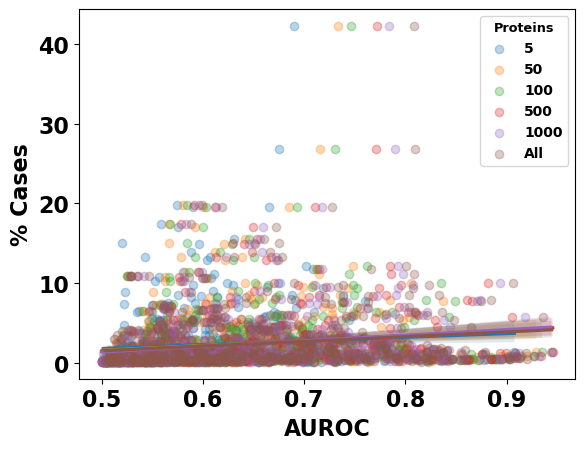

In [5]:
pdf = group_median[group_median.auroc >= 0.5]

label_dict = {'auroc': 'AUROC', 'prec_pos': 'Precision', 'avg_prec': "Average Precision", 'f1_pos': 'F1 Positive', 'percent_cases': '% Cases'}
x_col = 'auroc'
y_col = 'percent_cases'
sk = {'alpha': 0.3}
sns.regplot(data=pdf.loc[(5)], x=x_col, y=y_col, scatter_kws=sk, label='5' )
sns.regplot(data=pdf.loc[(50)], x=x_col, y=y_col, scatter_kws=sk, label='50')
sns.regplot(data=pdf.loc[(100)], x=x_col, y=y_col, scatter_kws=sk, label='100')
sns.regplot(data=pdf.loc[(500)], x=x_col, y=y_col, scatter_kws=sk, label='500')
sns.regplot(data=pdf.loc[(1000)], x=x_col, y=y_col, scatter_kws=sk, label='1000')
sns.regplot(data=pdf.loc[(2923)], x=x_col, y=y_col, scatter_kws=sk, label='All')
legend = plt.legend(title="Proteins", fontsize=10)
plt.ylabel(label_dict[y_col], fontweight='bold')
plt.xlabel(label_dict[x_col], fontweight='bold')
plt.setp(legend.get_title(),fontsize='xx-small')


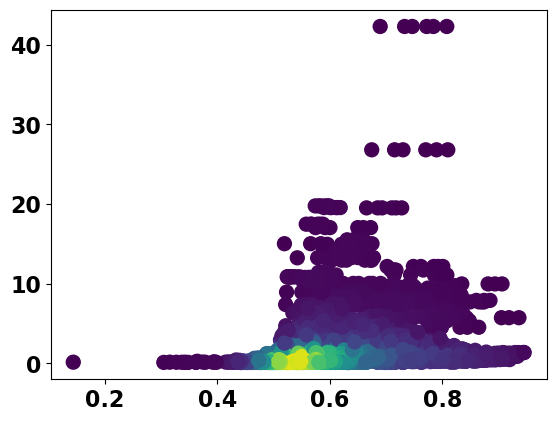

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

plot_df

x = group_median.auroc
y = group_median.percent_cases

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
plt.show()

In [10]:
sum(group_median.percent_cases==0)

0

(array([1.000e+00, 0.000e+00, 1.300e+01, 5.300e+01, 8.960e+02, 1.254e+03,
        7.210e+02, 4.080e+02, 2.170e+02, 7.900e+01]),
 array([0.1440751 , 0.22423687, 0.30439864, 0.38456041, 0.46472218,
        0.54488395, 0.62504572, 0.70520749, 0.78536926, 0.86553103,
        0.9456928 ]),
 <BarContainer object of 10 artists>)

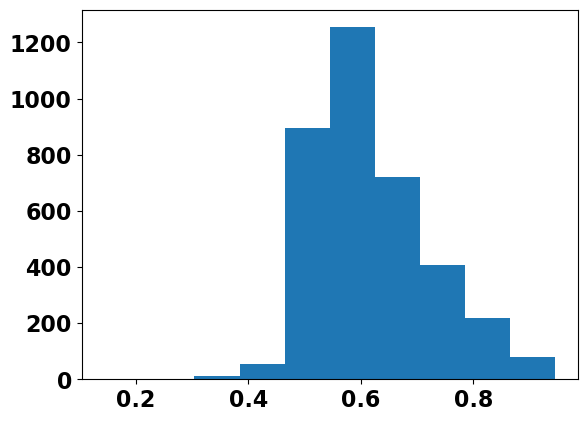

In [6]:
plt.hist(group_median.auroc)

In [72]:
group_median[group_median.percent_cases > 20]

TN      FP      FN      TP     auroc  avg_prec  \
n_features outcome                                                       
5          130814   3805.0  3880.0   656.0  2155.5  0.674663  0.398674   
           131286   2392.0  3668.0   679.0  3758.0  0.689695  0.597718   
50         130814   4455.0  3230.0   755.5  2056.0  0.715297  0.459271   
           131286   2983.0  3077.0   781.0  3656.0  0.733175  0.659775   
100        130814   4738.0  2947.0   786.0  2025.0  0.730289  0.484145   
           131286   3148.0  2912.0   812.0  3625.0  0.746779  0.679065   
500        130814   5608.0  2077.5   941.0  1870.0  0.770742  0.566516   
           131286   3555.0  2505.0   883.0  3554.0  0.772373  0.718169   
1000       130814   5958.0  1728.0   991.0  1821.0  0.789865  0.602085   
           131286   3655.0  2405.0   890.0  3547.0  0.784209  0.735775   
2923       130814   6322.0  1363.0  1017.0  1795.0  0.809879  0.633928   
           131286   3783.0  2277.0   828.0  3609.0  0.808099  0.767748   

                    best_thresh   best_f1  accuracy  balanced_acc  prec_neg  \
n_features outcome                                                            
5          130814      0.462181  0.485386  0.567591      0.628440  0.852512   
           131286      0.383841  0.632957  0.586453      0.621277  0.778686   
50         130814      0.466189  0.509443  0.621225      0.656974  0.856774   
           131286      0.393675  0.653353  0.629608      0.656182  0.791549   
100        130814      0.471905  0.521029  0.645899      0.668589  0.857934   
           131286      0.400864  0.660244  0.645613      0.668095  0.794737   
500        130814      0.500154  0.555106  0.711727      0.698631  0.857186   
           131286      0.408941  0.674832  0.674478      0.690985  0.800364   
1000       130814      0.512957  0.573377  0.741640      0.711845  0.857185   
           131286      0.410694  0.682281  0.687339      0.701998  0.803994   
2923       130814      0.531349  0.601558  0.773269      0.730480  0.861425   
           131286      0.397105  0.699500  0.704392      0.719022  0.820321   

                    prec_pos   rec_neg   rec_pos    f1_neg    f1_pos  n_cases  \
n_features outcome                                                              
5          130814   0.356432  0.495120  0.766673  0.626366  0.485223   2812.0   
           131286   0.506545  0.394719  0.846969  0.524038  0.632845   4437.0   
50         130814   0.390558  0.579701  0.731282  0.690989  0.509258   2812.0   
           131286   0.540921  0.492244  0.823980  0.605949  0.653231   4437.0   
100        130814   0.408903  0.616526  0.720384  0.718290  0.520843   2812.0   
           131286   0.555013  0.519472  0.816993  0.628571  0.660126   4437.0   
500        130814   0.472489  0.729686  0.665244  0.787547  0.554897   2812.0   
           131286   0.584069  0.586634  0.800992  0.675450  0.674709   4437.0   
1000       130814   0.514265  0.775176  0.647582  0.814923  0.573145   2812.0   
           131286   0.596863  0.603135  0.799414  0.690055  0.682156   4437.0   
2923       130814   0.568373  0.822642  0.638336  0.841587  0.601324   2812.0   
           131286   0.613256  0.624257  0.813387  0.709079  0.699366   4437.0   

                    n_controls  percent_cases  
n_features outcome                             
5          130814       7685.0      26.788606  
           131286       6060.0      42.269220  
50         130814       7685.0      26.788606  
           131286       6060.0      42.269220  
100        130814       7685.0      26.788606  
           131286       6060.0      42.269220  
500        130814       7685.0      26.788606  
           131286       6060.0      42.269220  
1000       130814       7685.0      26.788606  
           131286       6060.0      42.269220  
2923       130814       7685.0      26.788606  
           131286       6060.0      42.269220

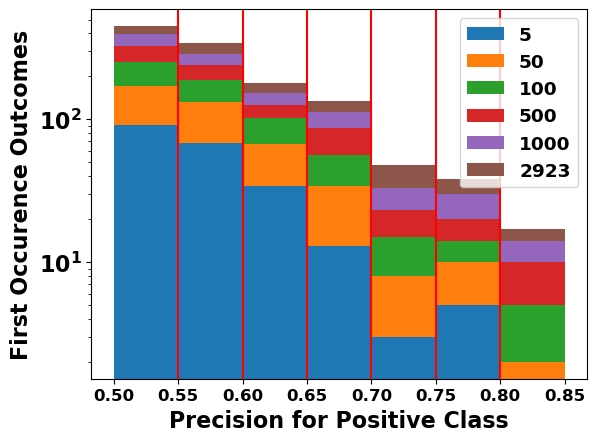

In [106]:
marker_range = np.arange(0.5,0.9,0.05)
metric = 'AUROC'
newcols = []
for nf in [5, 50, 100, 500, 1000, 2923]:
 newcols.append(dfres[dfres.n_features == nf][metric])

df_newcols = pd.concat(newcols, axis=1)
df_newcols.columns = [str(x) for x in [5, 50, 100, 500, 1000, 2923]]

plt.hist(df_newcols, bins = marker_range, 
    histtype='bar', stacked=True, label = [5, 50, 100, 500, 1000, 2923], log=True)
plt.legend(fontsize='small')
plt.ylabel("First Occurence Outcomes", weight='bold')
plt.xlabel("Precision for Positive Class", weight='bold')

# Adjust font properties for x-axis tick labels
plt.tick_params(axis='x', labelsize=12)  # Set font size for x-axis tick labels

for mark in marker_range[1:-1]:
    plt.vlines(mark, ymin=0.5, ymax=900, color='red')

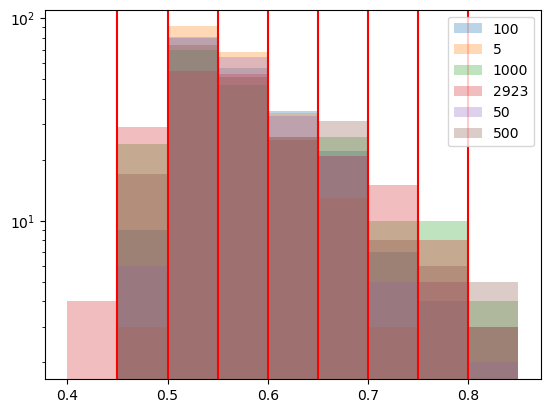

In [59]:
for nf in [5, 50, 100, 500, 1000, 2923]:
    plt.hist(dfres[dfres.n_features == nf].AUROC, bins=marker_range, log=True, alpha=0.3, label=nf)
    plt.legend()

for mark in marker_range[1:-1]:
    plt.vlines(mark, ymin=0.5, ymax=500, color='red')
    # plt.vlines(0.6, ymin=0.5, ymax=500, color='k')
    # plt.vlines(0.7, ymin=0.5, ymax=500, color='k')
    # plt.vlines(0.8, ymin=0.5, ymax=500, color='k')